In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy import ndimage

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ds = pd.read_csv('/content/drive/MyDrive/Modelar_UH2022_agg.txt',sep = '|')
ds['SAMPLETIME'] = pd.to_datetime(ds['SAMPLETIME'], infer_datetime_format=True)  
ds = ds.sort_values(by=['ID', 'SAMPLETIME'])

In [228]:
ds.head()

#sacamos el dia de la semana y el dia del año que correspone a cada muestra
yearday = np.zeros(365)
yearday[:365-31] = np.arange(31,365)+1
yearday[365-31:] = np.arange(31)+1# dia del año de la muestra (los datos empiezan en febrero, por eso es un array movido)
scaler = [np.max(yearday), np.min(yearday)]
yearday = (np.array(yearday)-scaler[1])/(scaler[0]-scaler[1])

weekday = np.arange(1,8)
weekday = np.tile(weekday,53)[:365] # dia de la semana de la muestra
scaler = [np.max(weekday), np.min(weekday)]
weekday = (np.array(weekday)-scaler[1])/(scaler[0]-scaler[1])

In [5]:
#bloque de código de Jose para separar las series y hacer zero padding
ts = []
ids = []

for serie in ds['ID'].unique():
  
    serie_samples = pd.Series(data=np.zeros(365),index=ds['SAMPLETIME'].unique())
    sample = ds.loc[ds['ID'] == serie, 'DELTA']
    sample.index = ds.loc[ds['ID'] == serie, 'SAMPLETIME']
    serie_samples.loc[ds.loc[(ds['ID'] == serie), 'SAMPLETIME']] = sample
    ts.append(serie_samples)
    ids.append(serie)

ts = np.array(ts).T

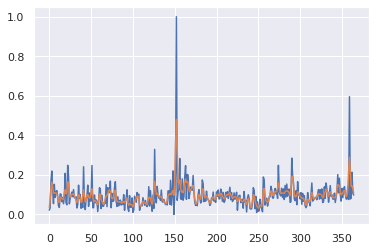

In [237]:
df = pd.DataFrame(ts)

muestra = df.iloc[:,1800]
scaler = [np.max(muestra), np.min(muestra)]
muestra_sin = (np.array(muestra)-scaler[1])/(scaler[0]-scaler[1])
df.iloc[:,0] = muestra

muestra=ndimage.gaussian_filter(muestra_sin,sigma = 1)

train = muestra[0:330]
valid = muestra[330:]

fig = plt.figure()
plt.plot(muestra_sin)
plt.plot(muestra)

# Model

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Lambda
from keras.layers import LSTM,Conv1D,Flatten
import tensorflow as tf

In [238]:
weights = np.exp((np.arange(60)-60)/10)
weights

array([0.00247875, 0.00273944, 0.00302755, 0.00334597, 0.00369786,
       0.00408677, 0.00451658, 0.00499159, 0.00551656, 0.00609675,
       0.00673795, 0.00744658, 0.00822975, 0.00909528, 0.01005184,
       0.011109  , 0.01227734, 0.01356856, 0.01499558, 0.01657268,
       0.01831564, 0.02024191, 0.02237077, 0.02472353, 0.02732372,
       0.03019738, 0.03337327, 0.03688317, 0.0407622 , 0.0450492 ,
       0.04978707, 0.05502322, 0.06081006, 0.06720551, 0.07427358,
       0.082085  , 0.09071795, 0.10025884, 0.11080316, 0.12245643,
       0.13533528, 0.14956862, 0.16529889, 0.18268352, 0.20189652,
       0.22313016, 0.24659696, 0.27253179, 0.30119421, 0.33287108,
       0.36787944, 0.40656966, 0.44932896, 0.4965853 , 0.54881164,
       0.60653066, 0.67032005, 0.74081822, 0.81873075, 0.90483742])

In [239]:
#Preparamos los datos, hacemos una lista en la que cada elemento es otra lista con 60 dias anteriores pesados de manera exponencial para entrenar 
#y_train es el valor para entrenar
x_train, week_train, year_train, y_train = [], [], [], []
for i in range(60,len(train)):
    x_train.append(muestra[i-60:i]*weights)#60 dias anteriores pesados exponencialmente (cuano más lejano al dia a predecir menos peso)
    week_train.append(weekday[i-60:i])
    year_train.append(yearday[i-60:i])
    y_train.append(muestra[i])
x_train, y_train = np.array(x_train), np.array(y_train)

aux = np.zeros([270,60,3])
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))#Adaptamos la forma para que entre en la LSTM


#Esto es un intento de meter también el dia del año y el de la semana en los datos, de momento está en deshuso

#aux[:,:,0]=x_train
#aux[:,:,1]= week_train
#aux[:,:,2]= year_train


In [240]:
#Red neuronal (tocad lo que querais que lo hice sin saber mucho que estaba haciendo)
model = Sequential([
                LSTM(128,input_shape= (60,1), return_sequences=True, use_bias=True),
                LSTM(60),
                #Conv1D(5, 3),
                #Flatten( input_shape=(10,1)),
                Dense(units=1)
            ])

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7f3c1e084fd0>>

In [241]:
#Lo mismo que con los datos de train
inputs = muestra[(len(muestra[:]) - len(valid) - 60):]
week_ = weekday[(len(muestra[:]) - len(valid) - 60):]
year_ = yearday[(len(muestra[:]) - len(valid) - 60):]
inputs = inputs.reshape(-1,1)

X_test, week_test, year_test = [], [],[]
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0]*weights)
    week_test.append(week_[i-60:i])
    year_test.append(year_[i-60:i])

X_test = np.array(X_test)
y_test = valid
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))


#aux2 = np.zeros([35,60,3])
#aux2[:,:,0]=X_test
#aux2[:,:,1]= week_test
#aux2[:,:,2]= year_test

In [242]:
history = model.fit(x_train,y_train,validation_data=(X_test, y_test),epochs=50)

Epoch 1/50
9/9 [==============================] - 5s 207ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 2/50
9/9 [==============================] - 1s 99ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 3/50
9/9 [==============================] - 1s 99ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 4/50
9/9 [==============================] - 1s 101ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 5/50
9/9 [==============================] - 1s 135ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 6/50
9/9 [==============================] - 1s 160ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 7/50
9/9 [==============================] - 1s 138ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 8/50
9/9 [==============================] - 1s 102ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 9/50
9/9 [==============================] - 1s 101ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 10/50
9/9 [==============================] - 1s 105ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 11/50
9/9 [====

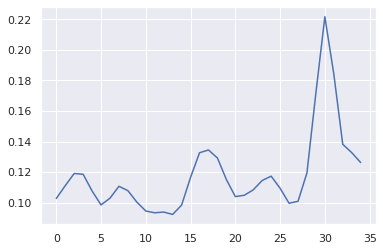

In [243]:
consumption_pred_ = model.predict(X_test)
consumption_pred_.shape
plt.plot(consumption_pred_)

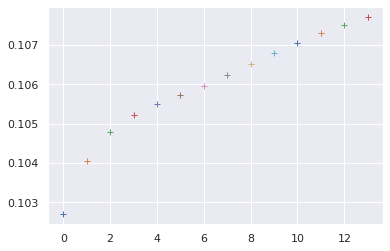

In [247]:
#Predecimos para dos semanas, cada valor predicho se introduce en los datos de entrenamiento
pred_vec = inputs[60-60:60,0].copy()
pred_vec1 = inputs[60-60:60,0]
preds = []


for i in range(14):
  
  Xw = np.zeros([1,60,1])
  Xw[0,:,0] = (pred_vec*weights)
  
  consumption_pred = model.predict(Xw)
  plt.plot(i,consumption_pred,"+")
  preds.append(consumption_pred)

  pred_vec[:59] = pred_vec[1:]# avanzamos un dia el vector de entrenamiento, sustituyendo el último dia por la predicción
  pred_vec[59] = consumption_pred
preds = np.array(preds).reshape([14])

In [73]:
consumption_pred.shape

(1, 60, 1)

# Resultados

In [252]:
serie = df.iloc[:,1800]

preds_= preds*(scaler[0]-scaler[1])+scaler[1]

consumption_pred_trans = consumption_pred_*(scaler[0]-scaler[1])+scaler[1]

rmse = np.sqrt(np.sum(np.square(serie[330:330+14]-preds_)))
print(rmse)

11676.592694096902


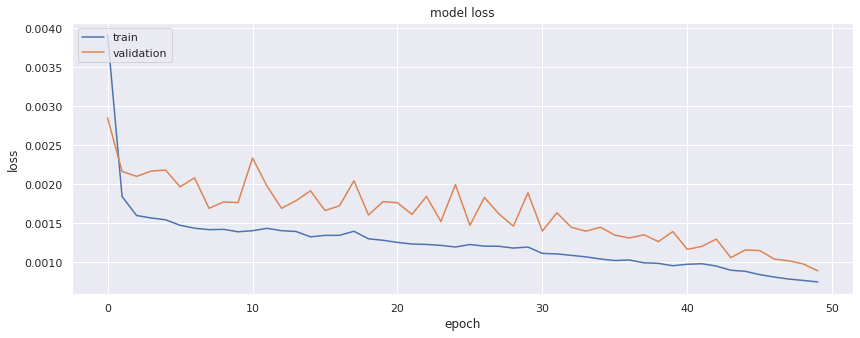

In [249]:
sns.set_theme()
plt.figure(figsize=(14,5))
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')


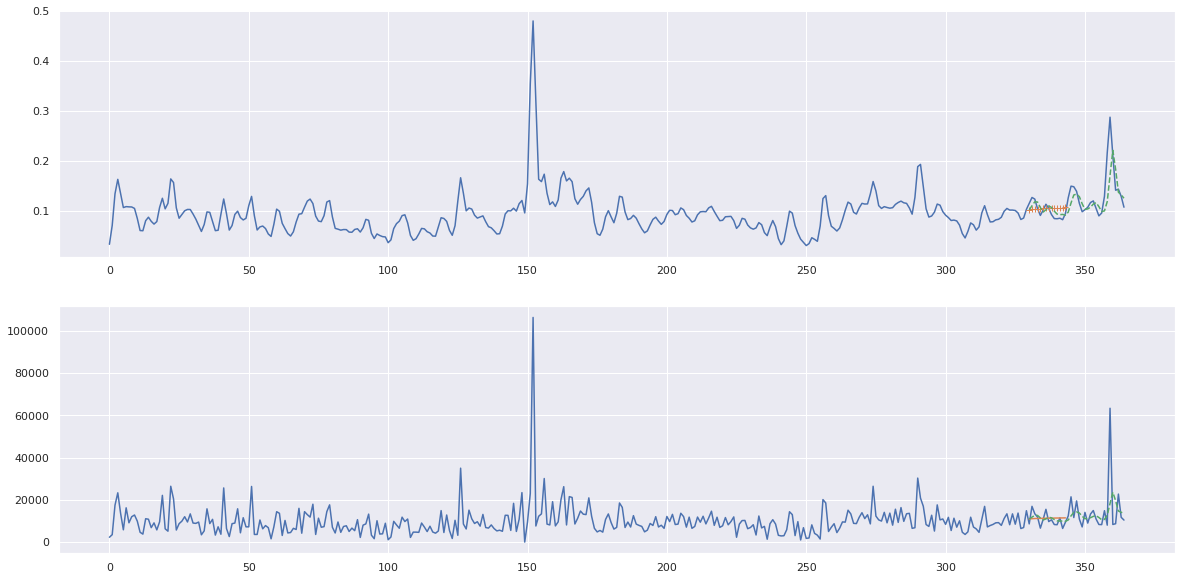

In [253]:
fig,(ax,bx) = plt.subplots(2,1, figsize = [20,10])
ax.plot(muestra)
#ax.plot(np.arange(60,330),y_train)
#ax.plot(np.arange(330,365),y_test)
ax.plot(np.arange(330,330+14),preds,"+")
ax.plot(np.arange(330,365),consumption_pred_,"--")

bx.plot(serie)
bx.plot(np.arange(330,330+14),preds_)
bx.plot(np.arange(330,365),consumption_pred_trans,"--")